In [ ]:
'''
To do:
1. Add cell for !pip install
2. Consolidate, organize, and label cells
3. Calls to all info for song data
4. Calls to all info for audio data
5. Merge streaming and API data yahya 
6. Chart songs, albums, artists over time
7. Clean up unique ids for compilations
'''

In [1]:
# Install necessary packages

!pip install pandas matplotlib seaborn spotipy requests
print("Installed all necessary packages.")

In [2]:
# Import needed libraries

import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys
import requests
import base64
from urllib.parse import urlencode


print("Imported necessary libraries.")

Imported necessary libraries.


In [9]:
# Establish API connection

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

client_id = "1956e71b71d2447f8ea8061325a6683c"
client_secret = "a76b7c0d30f44d7f8c392a4a18d56098"

# Set up authorization
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

token = auth_manager.get_access_token()

print(f"Established connection to Spotipy API. \nToken is {token}")

Established connection to Spotipy API. 
Token is {'access_token': 'BQBYstZT5RL5jPmpoFEFD4MyXvrp777Nh_L7sw2mXiK0lDV-YCYD5oSuQ0aIW-69tRX9DrZ-9G27q81wGP4SNXTJxYEDdQeJ28A3Ixkwt_nipvW3hvA', 'token_type': 'Bearer', 'expires_in': 3600, 'expires_at': 1733886316}


/var/folders/sv/67hlh2m91jnczt66yw3vcqf80000gp/T/ipykernel_32039/3610599391.py:13: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  token = auth_manager.get_access_token()


In [10]:
# For all accounts, combine all json files in the export folder

paths = ['mmcmm', 'thing21']

for path in paths:

    # Path to the folder containing JSON files
    folder_path = 'rd/' + path + '/'  
    
    # List all JSON files in the folder
    json_files = glob.glob(os.path.join(folder_path, "*.json"))
    
    # Initialize an empty list to hold DataFrames
    dataframes = []
    
    # Loop through each JSON file and read it into a DataFrame
    for file in json_files:
        try:
            df = pd.read_json(file)  # Read JSON file into a DataFrame
            dataframes.append(df)    # Append the DataFrame to the list
        except ValueError as e:
            print(f"Error reading {file}: {e}")
    
    # Concatenate all DataFrames into a single DataFrame
    final_df = pd.concat(dataframes, ignore_index=True)
    
    # Output the final DataFrame to a CSV file
    output_file = 'outputs/' + path + 'streams.csv'  
    final_df.to_csv(output_file, index=False)
    
    print(f"{path} data saved as {output_file}")

mmcmm data saved as outputs/mmcmmstreams.csv
thing21 data saved as outputs/thing21streams.csv


In [11]:
# Clean and combine data for all accounts

mmcmmdata = pd.read_csv('outputs/mmcmmstreams.csv', low_memory=False)
thing21data = pd.read_csv('outputs/thing21streams.csv', low_memory=False)

alldata = [mmcmmdata, thing21data]
names = ['mmcmm', 'thing21']

for idx, data in enumerate(alldata):
    # Perform data cleaning and transformations
    del data['user_agent_decrypted']
    data['ts'] = pd.to_datetime(data['ts'])
    data['skipped'] = data['skipped'].astype(bool)
    data['offline'] = data['offline'].astype(bool)
    data['incognito_mode'] = data['incognito_mode'].astype(bool)
    data['offline_timestamp'] = data['offline_timestamp'].replace([float('inf'), float('-inf')], None)
    data['offline_timestamp'] = data['offline_timestamp'].fillna(0)
    data['offline_timestamp'] = data['offline_timestamp'].astype(int)
    data['offline_timestamp'] = pd.to_datetime(data['offline_timestamp'], unit='s', errors='coerce')

# Concatenate all DataFrames into a single DataFrame
streams = pd.concat(alldata, ignore_index=True)

# Output the final DataFrame to a CSV file
output_name = 'outputs/combined.csv'  
streams.to_csv(output_name, index=False)

print(f"Combined CSV of all streams saved as {output_name}. Used in code as streams.")

Combined CSV of all streams saved as outputs/combined.csv. Used in code as streams


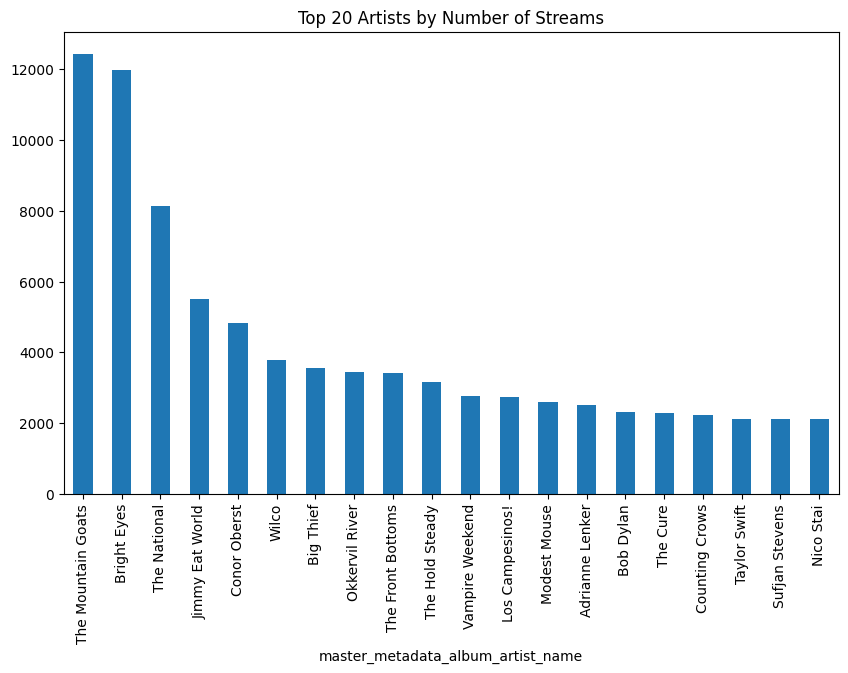

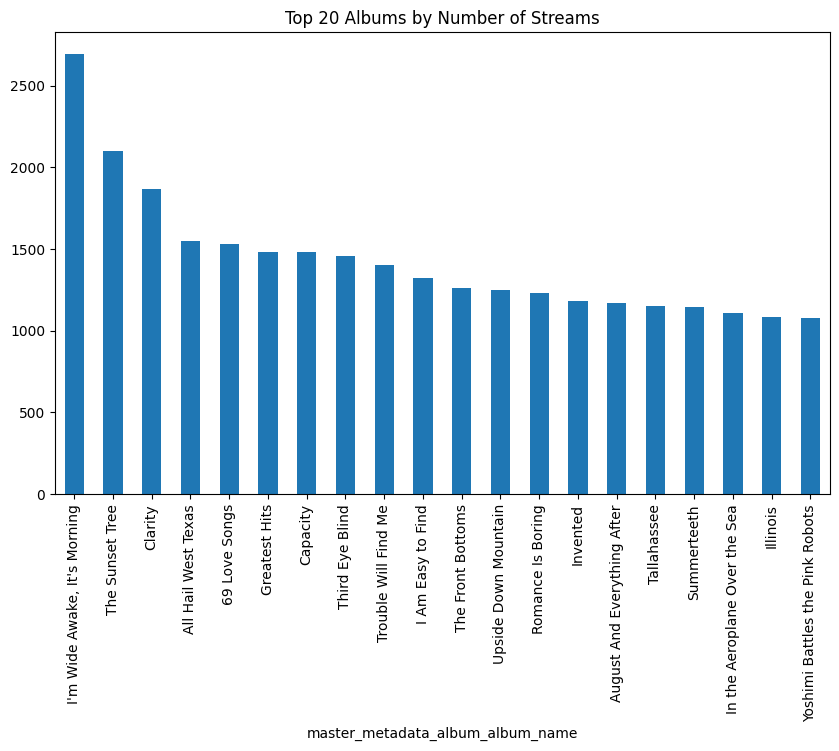

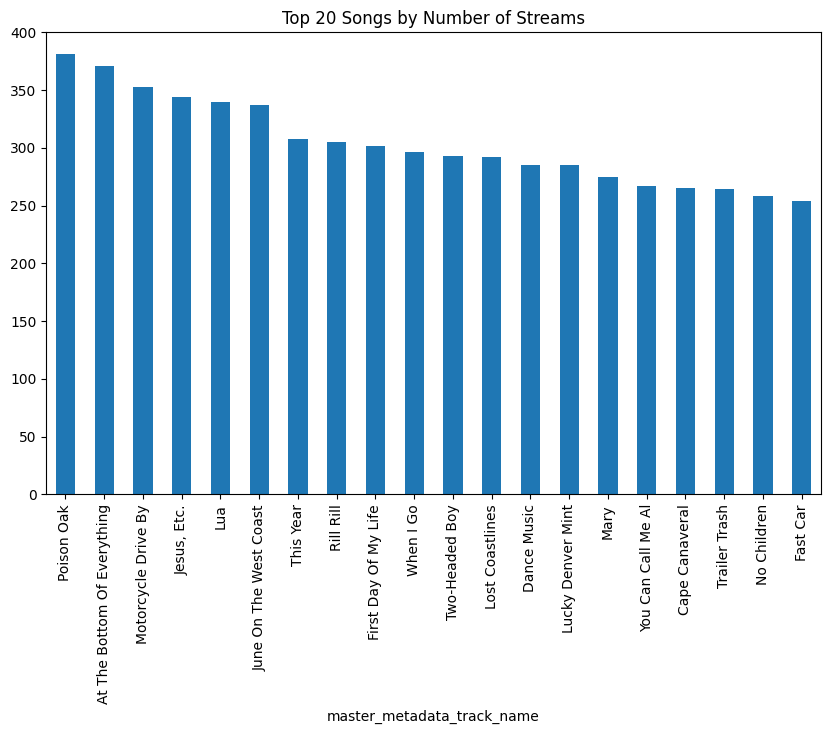

In [16]:
# Lifetime rankings by streams

# Top Artists by Play Count
top_artists = streams['master_metadata_album_artist_name'].value_counts().head(20)
# print("Top 20 Artists by Play Count:")
# print(top_artists)

plt.figure(figsize=(10,6))
top_artists.plot(kind='bar')
plt.title("Top 20 Artists by Number of Streams")
plt.show()

# Top Albums by Play Count
top_albums = streams['master_metadata_album_album_name'].value_counts().head(20)
# print("Top 20 Albums by Play Count:")
# print(top_albums)

plt.figure(figsize=(10,6))
top_albums.plot(kind='bar')
plt.title("Top 20 Albums by Number of Streams")
plt.show()

# Top Songs by Play Count
top_songs = streams['master_metadata_track_name'].value_counts().head(20)
# print("Top 20 Songs by Play Count:")
# print(top_songs)

plt.figure(figsize=(10,6))
top_songs.plot(kind='bar')
plt.title("Top 20 Songs by Number of Streams")
plt.show()

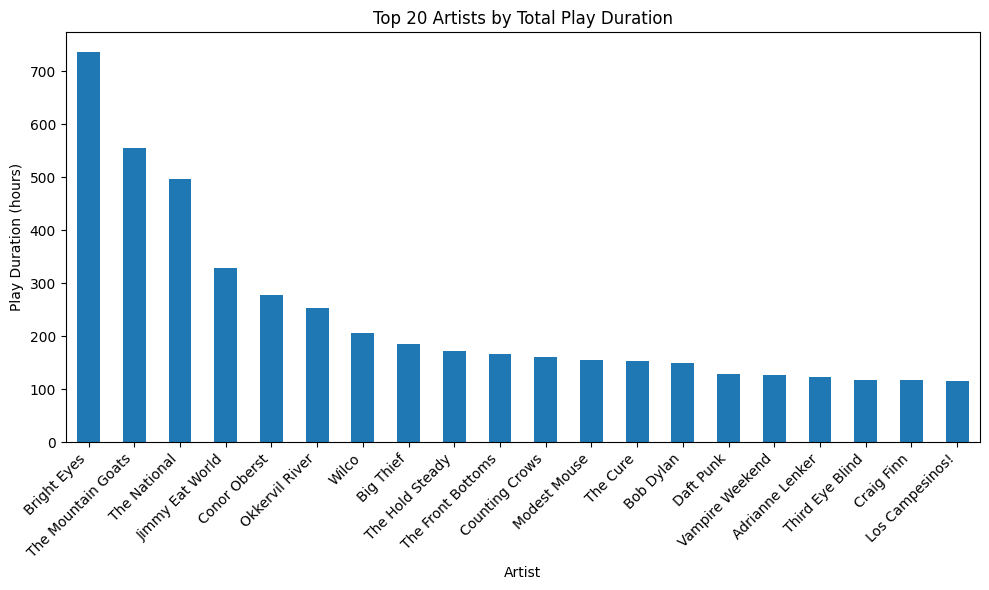

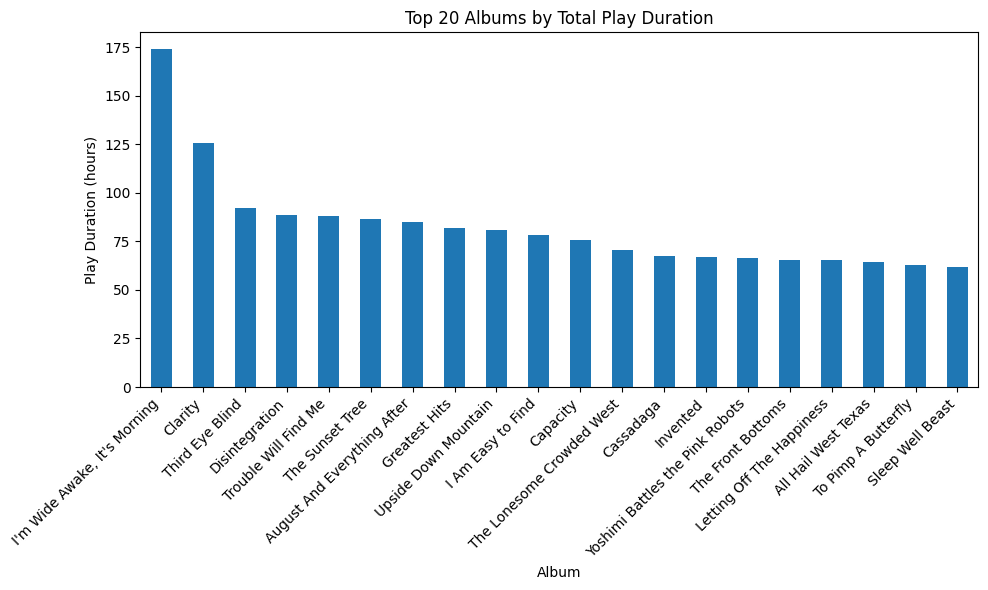

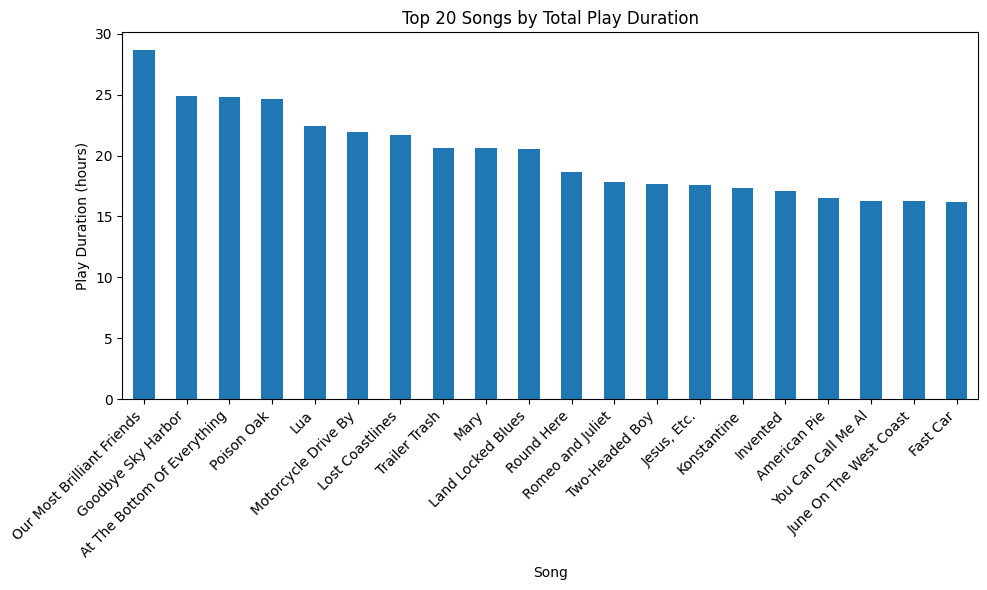

In [17]:
# lifetime rankings by duration

# Top Artists by Total Play Duration
top_artists = streams.groupby('master_metadata_album_artist_name')['ms_played'].sum().div(3600000).sort_values(ascending=False).head(20)
# print("Top 20 Artists by Total Play Duration (hours):")
# print(top_artists)

plt.figure(figsize=(10, 6))
top_artists.plot(kind='bar')
plt.title("Top 20 Artists by Total Play Duration")
plt.xlabel("Artist")
plt.ylabel("Play Duration (hours)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Top Albums by Total Play Duration
top_albums = streams.groupby('master_metadata_album_album_name')['ms_played'].sum().div(3600000).sort_values(ascending=False).head(20)
# print("Top 20 Albums by Total Play Duration (hours):")
# print(top_albums)

plt.figure(figsize=(10, 6))
top_albums.plot(kind='bar')
plt.title("Top 20 Albums by Total Play Duration")
plt.xlabel("Album")
plt.ylabel("Play Duration (hours)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Top Songs by Total Play Duration
top_songs = streams.groupby('master_metadata_track_name')['ms_played'].sum().div(3600000).sort_values(ascending=False).head(20)
# print("Top 20 Songs by Total Play Duration (hours):")
# print(top_songs)

plt.figure(figsize=(10, 6))
top_songs.plot(kind='bar')
plt.title("Top 20 Songs by Total Play Duration")
plt.xlabel("Song")
plt.ylabel("Play Duration (hours)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

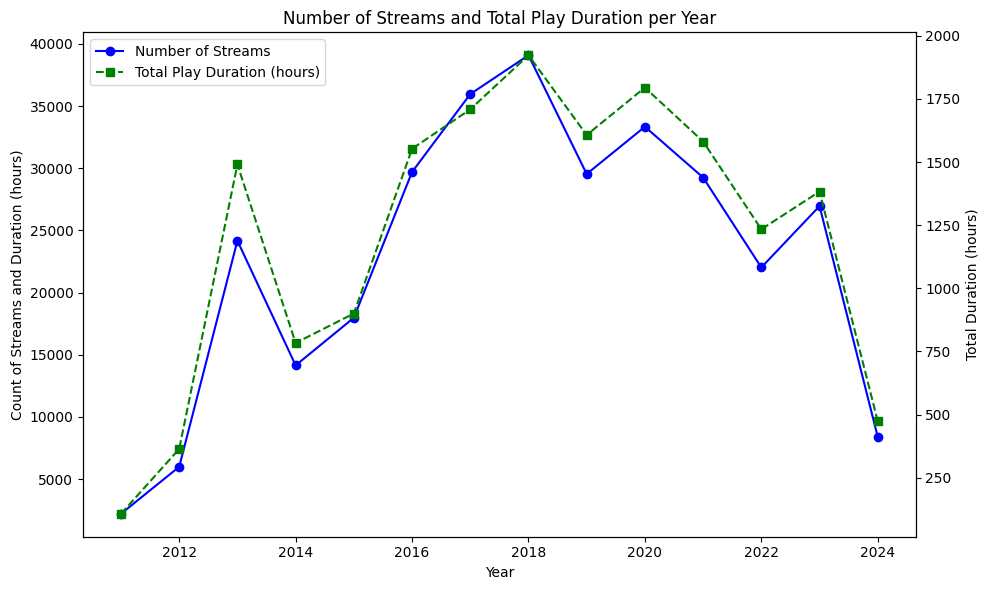

In [18]:
# Total play over lifetime

# Extracting time components
streams['year'] = streams['ts'].dt.year
streams['month'] = streams['ts'].dt.month

# Calculate total duration in hours per year
streams['hours_played'] = streams['ms_played'] / (1000 * 60 * 60)  # Convert ms to hours
yearly_duration = streams.groupby('year')['hours_played'].sum()

# Plotting the number of streams per year
yearly_counts = streams.groupby('year').size()
plt.figure(figsize=(10, 6))
yearly_counts.plot(marker='o', label='Number of Streams', color='blue')
plt.title("Number of Streams and Total Play Duration per Year")
plt.xlabel("Year")
plt.ylabel("Count of Streams")

# Plotting total play duration per year on a secondary y-axis
ax = plt.gca()
ax2 = ax.twinx()
yearly_duration.plot(marker='s', linestyle='--', label='Total Play Duration (hours)', color='green', ax=ax2)
ax2.set_ylabel("Total Duration (hours)")

# Combine legends
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()

In [22]:
# 1. Get unique track ids from streams
track_uris = streams['spotify_track_uri'].dropna().astype(str).unique().tolist()
track_ids = [uri.split(':')[-1] for uri in track_uris if 'spotify:track:' in uri]

if not track_ids:
    print("No valid track IDs found.")
else:
    print(f"Found {len(track_ids)} unique track IDs.")

# 2. Reference token as my access token
token_code = token['access_token']
headers = {
    "Authorization": f"Bearer {token_code}"
}

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

output_file = "track_data.csv"
all_results = []

# 3. Make batch calls to the tracks API
# We'll use: GET https://api.spotify.com/v1/tracks?ids=...
for i, track_chunk in enumerate(chunks(track_ids, 50)):
    # Construct the request
    url = "https://api.spotify.com/v1/tracks"
    params = {
        "ids": ",".join(track_chunk)
    }
    
    response = requests.get(url, headers=headers, params=params)
    if response.status_code != 200:
        print(f"Request failed with status {response.status_code}. Retrying in 30s...")
        time.sleep(30)
        continue
    
    data = response.json()
    tracks = data.get('tracks', [])
    
    # Extract desired fields from each track object
    for t in tracks:
        if t:
            track_info = {
                "track_id": t.get("id"),
                "track_name": t.get("name"),
                "album_name": t.get("album", {}).get("name"),
                "album_release_date": t.get("album", {}).get("release_date"),
                "album_id": t.get("album", {}).get("id"),
                "album_type": t.get("album", {}).get("album_type"),
                "artist_names": [artist["name"] for artist in t.get("artists", [])],
                "artist_ids": [artist["id"] for artist in t.get("artists", [])],
                "track_popularity": t.get("popularity"),
                "duration_ms": t.get("duration_ms"),
                "explicit": t.get("explicit"),
                "isrc": t.get("external_ids", {}).get("isrc"),
                "track_uri": t.get("uri")
            }
            all_results.append(track_info)
    
    # small delay to reduce risk of rate limits
    time.sleep(0.2)
    
    # 4. Save data intermittently (every 10 chunks)
    if i % 10 == 0 and i > 0:
        temp_df = pd.DataFrame(all_results)
        temp_df.to_csv(output_file, mode='a', header=not i, index=False)
        all_results = []
        print(f"Processed {i*50} tracks and saved to file.")

# Save any remaining results after the loop completes
if all_results:
    final_df = pd.DataFrame(all_results)
    # If we never wrote before, we need a header; if we did, no header is necessary
    # We'll include the header if it's the first time writing
    # Check if file exists:
    import os
    write_header = not os.path.exists(output_file)
    final_df.to_csv(output_file, mode='a', header=write_header, index=False)

print("Data collection complete!")


Found 50883 unique track IDs.
Processed 500 tracks and saved to file.
Processed 1000 tracks and saved to file.
Processed 1500 tracks and saved to file.
Processed 2000 tracks and saved to file.
Processed 2500 tracks and saved to file.
Processed 3000 tracks and saved to file.
Processed 3500 tracks and saved to file.
Processed 4000 tracks and saved to file.
Processed 4500 tracks and saved to file.
Processed 5000 tracks and saved to file.
Processed 5500 tracks and saved to file.
Processed 6000 tracks and saved to file.
Processed 6500 tracks and saved to file.
Processed 7000 tracks and saved to file.
Processed 7500 tracks and saved to file.
Processed 8000 tracks and saved to file.
Processed 8500 tracks and saved to file.
Processed 9000 tracks and saved to file.
Processed 9500 tracks and saved to file.
Processed 10000 tracks and saved to file.
Processed 10500 tracks and saved to file.
Processed 11000 tracks and saved to file.
Processed 11500 tracks and saved to file.
Processed 12000 tracks a

In [23]:
# Part 2: Enhance data

# Establish API connection

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

client_id = "1956e71b71d2447f8ea8061325a6683c"
client_secret = "a76b7c0d30f44d7f8c392a4a18d56098"

# Set up authorization
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

token = auth_manager.get_access_token()

print(f"Established connection to Spotipy API. \nToken is {token}")

/var/folders/sv/67hlh2m91jnczt66yw3vcqf80000gp/T/ipykernel_32039/2457180551.py:15: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  token = auth_manager.get_access_token()


Established connection to Spotipy API. 
Token is {'access_token': 'BQDXYXYMR3Jn0px-SIT11x_WAMR6gOv2n2gdrxDhBuDiNWaQnxRqYWFvKLx9uWymTpstMaayt5GtijfaZjl3ZR1hyKvYN8UpuCesYKYvGdimSH9vCKE', 'token_type': 'Bearer', 'expires_in': 3600, 'expires_at': 1733892354}


In [24]:
# If library.csv exists, load it; otherwise create an empty DataFrame

track_info_file = "library.csv"

if os.path.exists(track_info_file):
    track_info_df = pd.read_csv(track_info_file)
else:
    track_info_df = pd.DataFrame(columns=[
        'track_id', 'track_name', 'album_name', 'album_release_date', 'album_id', 'album_type',
        'artist_names', 'artist_ids', 'track_popularity', 'duration_ms', 'explicit', 'isrc',
        'ean', 'upc', 'external_urls', 'track_uri'
    ])

print("Current trackInfo DataFrame:")
display(track_info_df.head())


Current trackInfo DataFrame:


,track_id,track_name,album_name,album_release_date,album_id,album_type,artist_names,artist_ids,track_popularity,duration_ms,explicit,isrc,ean,upc,external_urls,track_uri


In [25]:
# Extract track IDs from spotify_track_uri field
track_uris = streams['spotify_track_uri'].dropna().astype(str).unique().tolist()
track_ids = [uri.split(':')[-1] for uri in track_uris if 'spotify:track:' in uri]

print(f"Found {len(track_ids)} unique track IDs in streams.")

Found 50883 unique track IDs in streams.


In [26]:
# Identify which track IDs are already known
known_ids = set(track_info_df['track_id'].dropna())
new_ids = [t for t in track_ids if t not in known_ids]

print(f"{len(new_ids)} track IDs are missing from trackInfo and need enrichment.")

50883 track IDs are missing from trackInfo and need enrichment.


In [28]:
# Fetch Missing Track Info from the Spotify API

headers = {
    "Authorization": f"Bearer {token['access_token']}"
}

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

new_data = []
url = "https://api.spotify.com/v1/tracks"

for i, chunk in enumerate(chunks(new_ids, 50)):
    params = {"ids": ",".join(chunk)}
    r = requests.get(url, headers=headers, params=params)
    if r.status_code != 200:
        print(f"Request failed with status {r.status_code}, waiting 30s before retrying...")
        time.sleep(30)
        continue
    response_data = r.json()
    tracks = response_data.get('tracks', [])
    for t in tracks:
        if t:
            new_data.append({
                "track_id": t.get("id"),
                "track_name": t.get("name"),
                "album_name": t.get("album", {}).get("name"),
                "album_release_date": t.get("album", {}).get("release_date"),
                "album_id": t.get("album", {}).get("id"),
                "album_type": t.get("album", {}).get("album_type"),
                "artist_names": [artist["name"] for artist in t.get("artists", [])],
                "artist_ids": [artist["id"] for artist in t.get("artists", [])],
                "track_popularity": t.get("popularity"),
                "duration_ms": t.get("duration_ms"),
                "explicit": t.get("explicit"),
                "isrc": t.get("external_ids", {}).get("isrc"),
                "ean": t.get("external_ids", {}).get("ean"),
                "upc": t.get("external_ids", {}).get("upc"),
                "external_urls": t.get("external_urls", {}),
                "track_uri": t.get("uri")
            })
    # small delay to reduce rate limit risks
    time.sleep(0.2)

new_data_df = pd.DataFrame(new_data)
print(f"Fetched metadata for {len(new_data_df)} new tracks.")

Fetched metadata for 50883 new tracks.


In [29]:
# Update new data to library
if not new_data_df.empty:
    # Write headers if library.csv was empty before
    write_header = (track_info_df.empty and not os.path.exists(track_info_file)) or (not os.path.exists(track_info_file))
    new_data_df.to_csv(track_info_file, mode='a', header=write_header, index=False)
    print(f"Appended new track metadata to {track_info_file}")
    
    # Reload track_info_df to include newly added data
    track_info_df = pd.read_csv(track_info_file)
else:
    print("No new track data to append.")

Appended new track metadata to trackInfo.csv


In [30]:
#Merge streams with library

# Ensure streams has a track_id column for merging
streams['track_id'] = streams['spotify_track_uri'].astype(str).apply(
    lambda x: x.split(':')[-1] if 'spotify:track:' in x else x
)

enriched_streams = streams.merge(track_info_df, on='track_id', how='left')

print("Enriched streams DataFrame:")
display(enriched_streams.head())


Enriched streams DataFrame:


,ts,username,platform,ms_played,conn_country,ip_addr_decrypted,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,...,artist_names,artist_ids,track_popularity,duration_ms,explicit,isrc,ean,upc,external_urls,track_uri
0,2023-06-21 23:57:07+00:00,31toafx7vfnkisvzjx4byuixhx5i,ios,202080,US,107.123.52.81,The Prophet,Slow Club,I Swam Out To Greet You,spotify:track:2kDhwX6rr3zcX5lQ34FwRu,...,['Slow Club'],['75Kh0eqgzo9f43Dan1JzSV'],1.0,209999.0,False,GBGEY1500011,NaN,NaN,{'spotify': 'https://open.spotify.com/track/2k...,spotify:track:2kDhwX6rr3zcX5lQ34FwRu
1,2023-06-21 23:59:49+00:00,31toafx7vfnkisvzjx4byuixhx5i,ios,161799,US,107.123.52.81,Motorcycle Drive By,Zach Bryan,Summertime Blues,spotify:track:2HbpYFQbairMoU2YFyOP2x,...,['Zach Bryan'],['40ZNYROS4zLfyyBSs2PGe2'],77.0,161799.0,False,USWB12202704,NaN,NaN,{'spotify': 'https://open.spotify.com/track/2H...,spotify:track:2HbpYFQbairMoU2YFyOP2x
2,2023-06-22 00:03:07+00:00,31toafx7vfnkisvzjx4byuixhx5i,ios,198560,US,107.123.52.81,"Dark Was the Night, Cold Was the Ground",Blind Willie Johnson,Dark Was The Night (Mojo Workin'- Blues For Th...,spotify:track:2P9nh9pTK96dE0b6NBbTSs,...,['Blind Willie Johnson'],['5kO4xdEKLuHHHPreu3UmkZ'],42.0,198560.0,False,USSM12700035,NaN,NaN,{'spotify': 'https://open.spotify.com/track/2P...,spotify:track:2P9nh9pTK96dE0b6NBbTSs
3,2023-06-22 00:06:09+00:00,31toafx7vfnkisvzjx4byuixhx5i,ios,181239,US,107.123.52.81,Summertime Blues,Zach Bryan,Summertime Blues,spotify:track:5jFqUtts2sSQsg5d7e42nI,...,['Zach Bryan'],['40ZNYROS4zLfyyBSs2PGe2'],49.0,181239.0,False,USWB12202705,NaN,NaN,{'spotify': 'https://open.spotify.com/track/5j...,spotify:track:5jFqUtts2sSQsg5d7e42nI
4,2023-06-22 00:09:42+00:00,31toafx7vfnkisvzjx4byuixhx5i,ios,211739,US,107.123.52.81,Oklahoma Smokeshow,Zach Bryan,Summertime Blues,spotify:track:0OWhKvvsHptt6vnnNUSM9a,...,['Zach Bryan'],['40ZNYROS4zLfyyBSs2PGe2'],79.0,211739.0,False,USWB12202706,NaN,NaN,{'spotify': 'https://open.spotify.com/track/0O...,spotify:track:0OWhKvvsHptt6vnnNUSM9a
